# **Board2Board Trainer**
**Approach**


1.   The training pipeline consists of two core components:
Piece Classification: A ResNet50 model (pretrained on ImageNet) is fine-tuned to classify chessboard squares into 13 categories. Input images (64×64 crops) are resized to 224×224 to match the ResNet50 architecture requirements. Dataset splitting is performed with splitfolders to create training and validation sets, and training is regularized using data augmentation, early stopping, and learning rate reduction.
2.   Threshold Prediction: Separate Linear Regression models are trained on hand-engineered image features to predict optimal thresholds for board detection (Hough Line threshold and Agglomerative Clustering threshold, both in primary and secondary processing stages). These thresholds are later integrated into the OpenCV-based board processor for robust grid extraction.







*Libraries that require installing*

In [ ]:
!pip install scikit-learn
!pip install split-folders

## ResNet50 Fine-Tuning
A transfer learning setup is used:
* The pretrained ResNet50 backbone is loaded with ImageNet weights, excluding its top classification layers.
* All layers are frozen initially, then the last 10 layers are unfrozen for fine-tuning.
* A custom head is attached: convolutional outputs are flattened, followed by a dense layer with 128 ReLU units, and a final softmax layer that outputs predictions for 13 classes (piece types + empty square).
* The model is compiled with the Adam optimizer and categorical cross-entropy loss.
* Training uses an 80/20 split with real-time data augmentation. Early stopping (based on validation accuracy) and ReduceLROnPlateau (on validation loss) ensure convergence without overfitting.

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import splitfolders
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Creating the Neural Network

# Loading the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Transfer Learning and Fine Tuning the Model on the custom dataset
for layer in base_model.layers:
  layer.trainable = False
#base_model.summary()

for layer in base_model.layers[-10:]:
  layer.trainable = True

# Create the final model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(13, activation='softmax')(x) #classify into 13 classes

output_layer = predictions

# Compiling the model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


# Training the model

# split the dataset: 80% training data and 20% validation data
splitfolders.ratio("/content/drive/MyDrive/dataset2",output="output_dataset", seed=42, ratio=(0.8, 0.2))

train_dir = "output_dataset/train"
val_dir = "output_dataset/val"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2])

val_datagen = ImageDataGenerator()

# 224x224 images are most suitable with ResNet50 model
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Early Stopping: check the validation accuracy
# if validation accuracy doesn't improve after 4 epoches, stop
# and restore the weights calculated in the highest accuracy epoch
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True
)

# Reduce Learning Rate where there is no improvement in validation loss
# fir 3 epoches
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Start training
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop,reduce_lr])

# Metrics
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

# Save model
model.save("board2board.h5")


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  2.81 files/s]
Copying files: 2 files [00:00,  2.78 files/s]
Copying files: 3 files [00:00,  3.17 files/s]
Copying files: 4 files [00:01,  2.95 files/s]
Copying files: 5 files [00:01,  3.35 files/s]
Copying files: 6 files [00:01,  3.39 files/s]
Copying files: 7 files [00:02,  3.06 files/s]
Copying files: 8 files [00:02,  3.20 files/s]
Copying files: 9 files [00:02,  3.35 files/s]
Copying files: 852 files [00:13, 364.67 files/s]
Copying files: 11 files [00:03,  3.30 files/s]
Copying files: 12 files [00:03,  3.59 files/s]
Copying files: 13 files [00:03,  3.61 files/s]
Copying files: 14 files [00:04,  3.52 files/s]
Copying files: 15 files [00:04,  3.64 files/s]
Copying files: 16 files [00:04,  3.61 files/s]
Copying files: 17 files [00:05,  3.58 files/s]
Copying files: 18 files [00:05,  3.48 files/s]
Copying files: 19 files [00:07,  1.08 files/s]
Copying files: 20 files [00:08,  1.36 files/s]
Copying files: 21 files 

Found 1055 images belonging to 13 classes.
Found 349 images belonging to 13 classes.



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 977ms/step - accuracy: 0.2967 - loss: 11.5864 - val_accuracy: 0.2722 - val_loss: 10.3772 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 461ms/step - accuracy: 0.6300 - loss: 1.0416 - val_accuracy: 0.2751 - val_loss: 6.3226 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.7787 - loss: 0.6716 - val_accuracy: 0.4986 - val_loss: 5.0803 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - accuracy: 0.8260 - loss: 0.5855 - val_accuracy: 0.5788 - val_loss: 2.1140 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 463ms/step - accuracy: 0.8448 - loss: 0.4262 - val_accuracy: 0.8481 - val_loss: 0.5002 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.8950 - loss: 0.2852 - val_accuracy: 0.7851 - val_loss: 0.8592 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.8879 - loss: 

Validation Loss: 0.20053713023662567, Validation Accuracy: 0.9484240412712097


**Performance Evaluation: Confusion Matrix**

To assess classification performance:
* A confusion matrix is computed by comparing predicted labels against true labels from the validation set.
* The results are visualized as a heatmap (using Seaborn) with class labels on both axes.
* A classification_report provides precision, recall, and F1 scores for each class. This combination allows both high-level accuracy monitoring and detailed insight into misclassifications between specific piece types.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


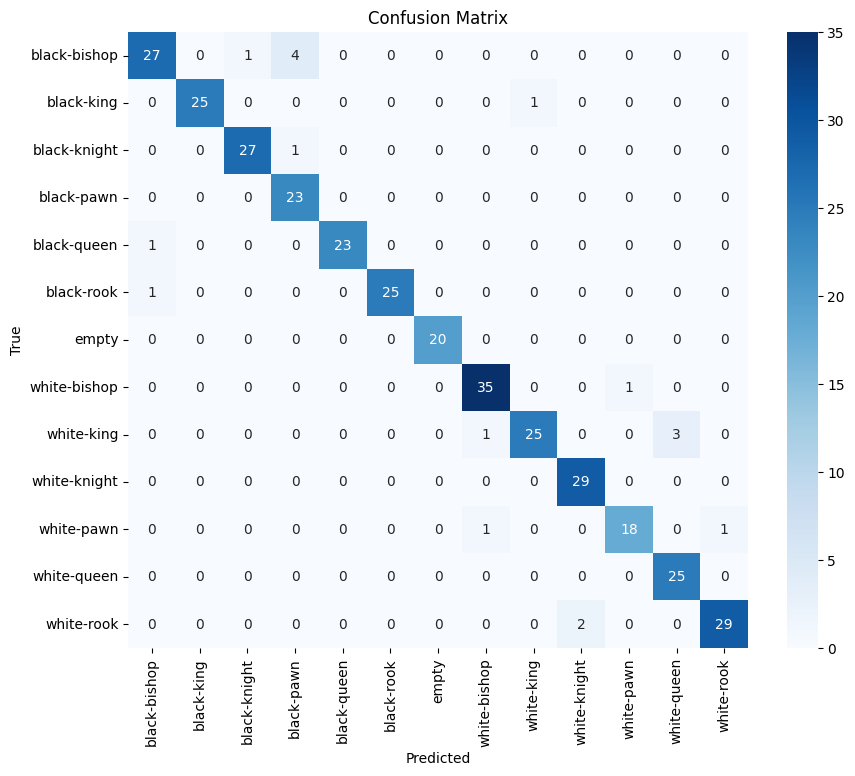

              precision    recall  f1-score   support

black-bishop       0.93      0.84      0.89        32
  black-king       1.00      0.96      0.98        26
black-knight       0.96      0.96      0.96        28
  black-pawn       0.82      1.00      0.90        23
 black-queen       1.00      0.96      0.98        24
  black-rook       1.00      0.96      0.98        26
       empty       1.00      1.00      1.00        20
white-bishop       0.95      0.97      0.96        36
  white-king       0.96      0.86      0.91        29
white-knight       0.94      1.00      0.97        29
  white-pawn       0.95      0.90      0.92        20
 white-queen       0.89      1.00      0.94        25
  white-rook       0.97      0.94      0.95        31

    accuracy                           0.95       349
   macro avg       0.95      0.95      0.95       349
weighted avg       0.95      0.95      0.95       349



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Confusion Matrix to ensure model is well trained
class_names = list(train_gen.class_indices.keys())

y_true = []
y_pred = []

for i in range(len(val_gen)):
    x_batch, y_batch = val_gen[i]
    y_true_batch = np.argmax(y_batch, axis=1)
    y_pred_batch = np.argmax(model.predict(x_batch), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)

    if i >= val_gen.__len__():
        break

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))


## Linear Regression for Threshold Prediction

While CNNs handle piece recognition, board detection relies on image-specific thresholds. To avoid manually tuning them, regression models are trained to predict thresholds directly from image features.

**Pipeline**
1.  Dataset Preparation: Each dataset (e.g., primary_hough_training.csv) contains numerical image descriptors (intensity, entropy, edge density, etc.) and the corresponding optimal threshold.
Train-Test Split: Data is divided into 80% training and 20% testing.
Feature Scaling: Standardization ensures features have zero mean and unit variance.
2.  Model Training: A LinearRegression model is fit on the scaled features.
3.  Evaluation: Predictions are compared against ground truth using MSE and R² metrics. Scatter plots visualize predicted vs. true thresholds.
4.  Pipeline Export: A scikit-learn pipeline (scaler + regression model) is serialized with Joblib for integration into the OpenCV board processor.

**Separate Models**
1.  *Primary Houghline Threshold* — predicts the line detection threshold for initial board extraction.
2.  *Primary Clustering Threshold* — predicts the distance parameter for clustering intersection points into grid corners.
3.  *Secondary Houghline Threshold* — refines thresholds after perspective correction.
4.  *Secondary Clustering Threshold* — adjusts clustering in the warped image stage.

Feature columns: ['mean_intensity', ' std_intensity', ' edge_density', ' gradient_mean', 'gradient_std', ' entropy', ' aspect_ratio', 'hough_threshold']
Mean Squared Error: 482.9887
R² Score: 0.7855
Learned Coefficients: [[-61.8014152   75.59447106 -61.8014152  -10.77325346  37.66158239
    5.40732163  -2.07623175]]
Intercept: [210.86956522]


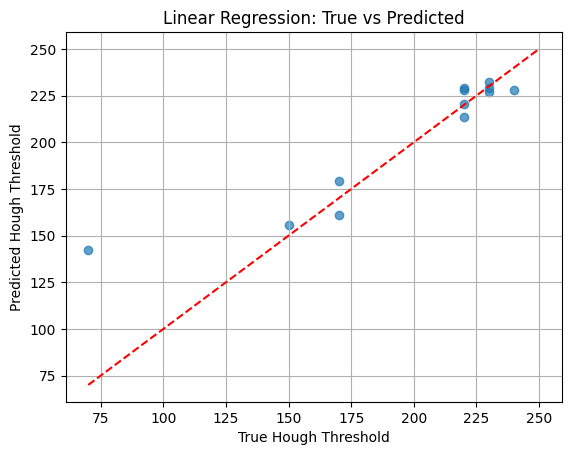

['primary_hough_pipeline.pkl']

In [ ]:
# Primary Houghline Threshold Linear Regression Pipeline

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

# 1. Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Board2Board/primary_hough_training.csv")

# Separate features and target
X = df.drop("hough_threshold", axis=1).values
y = df["hough_threshold"].values.reshape(-1, 1)

print("Feature columns:", df.columns.tolist())

# ----------------------------------------
# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train Linear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 5. Evaluate
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print("Learned Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# 6. Plot
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Hough Threshold")
plt.ylabel("Predicted Hough Threshold")
plt.title("Linear Regression: True vs Predicted")
plt.grid(True)
plt.show()

# 7. Save Model
pipeline = make_pipeline(scaler, model)
joblib.dump(pipeline, "primary_hough_pipeline.pkl")


['number of points', ' mean distance', ' std distance', ' cluster_threshold']
Feature columns: ['number of points', ' mean distance', ' std distance', ' cluster_threshold']
Mean Squared Error: 113.2673
R² Score: 0.6439
Learned Coefficients: [[  0.70749716  22.83819368 -13.99198007]]
Intercept: [102.2826087]


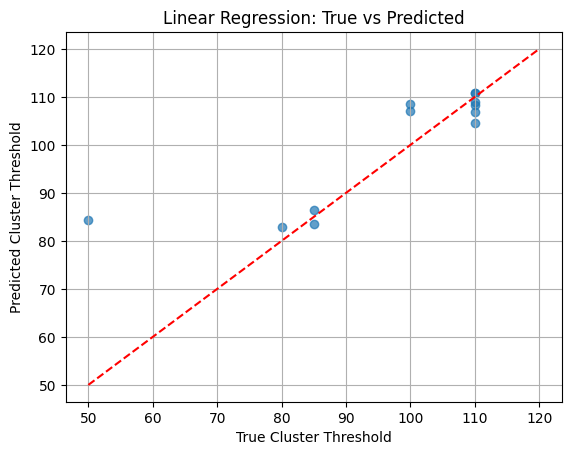

['primary_cluster_pipeline.pkl']

In [ ]:
# Primary Clustering Threshold Linear Regression Pipeline

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

# 1. Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Board2Board/primary_clustering_training.csv")
print(df.columns.tolist())

# Separate features and target
X = df.drop(" cluster_threshold", axis=1).values
y = df[" cluster_threshold"].values.reshape(-1, 1)

print("Feature columns:", df.columns.tolist())

# ----------------------------------------
# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train Linear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 5. Evaluate
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print("Learned Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# 6. Plot
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Cluster Threshold")
plt.ylabel("Predicted Cluster Threshold")
plt.title("Linear Regression: True vs Predicted")
plt.grid(True)
plt.show()

# 7. Save Model
pipeline = make_pipeline(scaler, model)
joblib.dump(pipeline, "primary_cluster_pipeline.pkl")


['mean_intensity', ' std_intensity', ' edge_density', ' gradient_mean', 'gradient_std', ' entropy', ' aspect_ratio', 'hough_threshold']
Feature columns: ['mean_intensity', ' std_intensity', ' edge_density', ' gradient_mean', 'gradient_std', ' entropy', ' aspect_ratio', 'hough_threshold']
Mean Squared Error: 577.9707
R² Score: 0.1986
Learned Coefficients: [[ 25.8839173  -51.89102248  25.8839173   17.06120838  -4.26469003
   -0.98198538   0.        ]]
Intercept: [173.63043478]


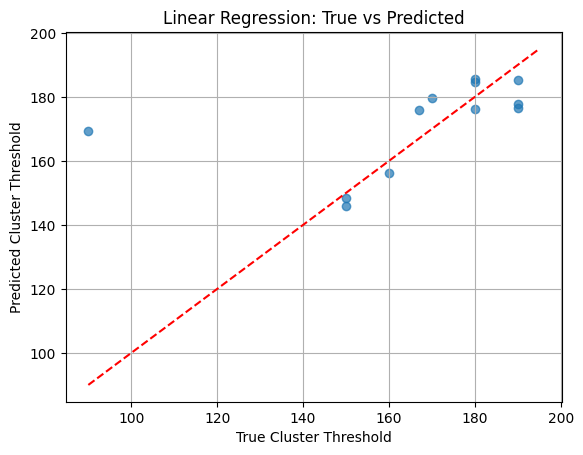

['secondary_hough_pipeline.pkl']

In [ ]:
# Secondary Houghline Threshold Linear Regression Pipeline


import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

# 1. Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Board2Board/secondary_hough_training.txt")
print(df.columns.tolist())

# Separate features and target
X = df.drop("hough_threshold", axis=1).values
y = df["hough_threshold"].values.reshape(-1, 1)

print("Feature columns:", df.columns.tolist())

# ----------------------------------------
# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train Linear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 5. Evaluate
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print("Learned Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# 6. Plot
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Houghline Threshold")
plt.ylabel("Predicted Houghline Threshold")
plt.title("Linear Regression: True vs Predicted")
plt.grid(True)
plt.show()

# 7. Save Model
pipeline = make_pipeline(scaler, model)
joblib.dump(pipeline, "secondary_hough_pipeline.pkl")


['number of points', ' mean distance', ' std distance', ' cluster_threshold']
Feature columns: ['number of points', ' mean distance', ' std distance', ' cluster_threshold']
Mean Squared Error: 36.5949
R² Score: 0.5220
Learned Coefficients: [[ 6.28038929 -6.46708244  6.86390295]]
Intercept: [86.23913043]


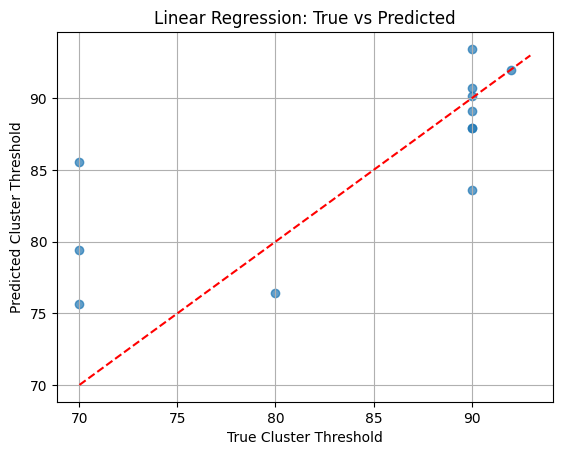

['secondary_cluster_pipeline.pkl']

In [ ]:
# Secondary Clustering Threshold Linear Regression Pipeline


import pandas as pd

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

# 1. Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Board2Board/secondary_clustering_training.txt")
print(df.columns.tolist())

# Separate features and target
X = df.drop(" cluster_threshold", axis=1).values
y = df[" cluster_threshold"].values.reshape(-1, 1)

print("Feature columns:", df.columns.tolist())

# ----------------------------------------
# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train Linear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 5. Evaluate
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print("Learned Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# 6. Plot
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Cluster Threshold")
plt.ylabel("Predicted Cluster Threshold")
plt.title("Linear Regression: True vs Predicted")
plt.grid(True)
plt.show()

# 7. Save Model
pipeline = make_pipeline(scaler, model)
joblib.dump(pipeline, "secondary_cluster_pipeline.pkl")


**© 2025 Jared Aung. All rights reserved.**
